# Fuzzy K-means with smoothing


Algorithm for FKM: [(Dias, 2019)](https://git.io/fuzzy-c-means)

Approach is based on:
[(Lark & Stafford, 1997)](https://onlinelibrary.wiley.com/doi/epdf/10.1111/j.1744-7348.1997.tb05787.x) and 
[(Lark, 1998)](https://doi.org/10.1080/136588198242021)

In [4]:
import numpy as np
from fcmeans import FCM
import matplotlib.pyplot as plt
import pandas as pd
import geopandas
import xarray as xr
from sklearn import preprocessing as prep

## Importing the data

In [5]:
vars_vec = np.array(['HCP1QP', 'PRP1QP', 'HCP2QP', 'PRP2QP', 'HCP4QP', 'PRP4QP'], dtype=np.dtype(object))

raster_files = list("Interpolations/IDW_10" + vars_vec + ".tiff")

stack_xr = xr.open_rasterio(raster_files[0])
stack_xr = stack_xr.assign_coords(band=("band", [vars_vec[0]]))
stack_xr = stack_xr.where(stack_xr != -999.)
stack_data = stack_xr.to_dataset(dim="band")

i=1
for file in raster_files[1:12]:
    layer = xr.open_rasterio(file)
    layer = layer.where(layer != -999.)
    layer_data = layer.to_dataset(dim="band")
    stack_data[str(vars_vec[i])]= layer.squeeze()
    i += 1

df_raster = stack_data.to_dataframe()[vars_vec]
rows_with_nan = df_raster.isnull().any(axis=1)
df_nona = df_raster[~rows_with_nan]
df_std = pd.DataFrame(prep.StandardScaler().fit_transform(df_nona))

## Fuzzy k-means

Hyperparameters:
* Fuzziness exponent (set to 1.5 in [Lark (1998)](https://doi.org/10.1080/136588198242021))
* Nr. of clusters, based on NCE.
    

In [9]:
## Function to calculate NCE 
## (in fuzzy-c-means, the particion entropy coefficient is calculated using log base 2, while in Lark paper it is calculated using base e)

def calc_NCE(fcm_model, k):
    u = 
    nce = (-np.sum(fcm_model.u * np.log(fcm_model.u)) / fcm_model.n_samples)/np.log(k)

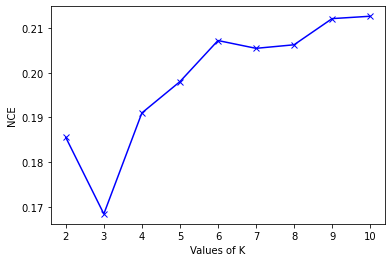

In [30]:
# Ideally should be repeated multiple times to avoid local minima of objective function

NCE = []
K = range(2,11)

for k in K:
    fcm = FCM(n_clusters = k, m=1.5, max_iter = 30000)
    fcm.fit(df_std)
    NCE.append(calc_NCE(fcm, k))

plt.plot(K, NCE, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('NCE')
plt.show()

In [31]:
# Optimal partition with k=3

fcm = FCM(n_clusters = 3, m=1.5, max_iter = 30000)
fcm.fit(df_std)
hard_memb = fcm.predict(df_std)
soft_memb = fcm.u

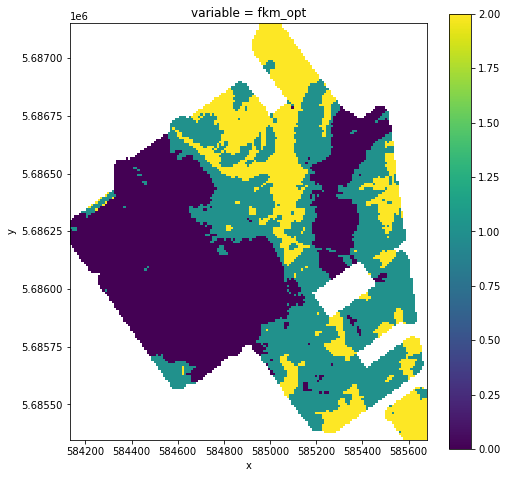

In [33]:
# The hard memberships can be used to plot the resulting classification

cl = np.empty((27540))
cl[:] = np.nan

cl[~rows_with_nan] = hard_memb

df_raster['fkm_opt'] = cl

xr_clusters = df_raster.to_xarray().transpose('y', 'x')

cl_array = xr_clusters.to_array()
ax = cl_array.sel(variable='fkm_opt').plot.pcolormesh(figsize=(8,8))
ax.axes.set_aspect('equal')

## Spatial smoothing of classification

This map is then smoothed to remove local variation in classification that is not very relevant. This is done using 
1) **The soft membership**: to know whether it is reasonable to reasign a pixel to a different class, it is more reasonable to do so if its maximum membership is small.
2) **A variogram model** of the EMI data to know how the structure of the spatial autocorrelation. It is more reasonable to reassign a pixel to the same class as its neighbors, if those neighbors are within the range for example.

Smoothing is done by adapting the soft membership values by taking a weighted average of the membership values of pixels within the neighborhood of the updated pixel, as in the following equation:\
$\mu^*_{i,g} = \sum_j{w_{i,j}\mu_{j,g}}, \quad \forall\, j \, \epsilon \, R$\

The weights $w_{i,j}$ are obtained from a variogram model fitted to the data.
A spherical variogram was fitted with nugget 15, sill 470 and range 828.

The part of the variogram model relevant to determine the weights is:\
$f(h_{ij})=\frac{3}{2} * \frac{h_{ij}}{a} - \frac{1}{2}*\frac{h_{ij}^3}{a^3}$\

The weights are then calculated by:\
$w_{i,j} = \frac{1 - f(h_{ij})}{\sum_k{(1 - f(h_{ij})},\, \forall\, k\,\epsilon\,R}\quad \forall\, j \, \epsilon \, R$